Цель работы: с помощью алгоритма Random Forest определить пригодность методов машинного обучения в задаче классификации шифрованного и нешифрованного трафика мобильных приложений.

Описание данных:

В распоряжении имеется файл наполненный трафиком шести мобильных приложений. Для каждого отдельного взятого потока имеется 24 описательных признака. Последним признаком является класс, то есть приложение к которому относится данный поток. Три приложения из шести используют шифрование трафика, оставшиеся три - нет.

# 1. Загрузка и подготовка данных

In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import OneHotEncoder

filepath = './csv_result-data_all.csv'
data = pd.read_csv(filepath, index_col = 'id')
data.head()

,Network_Layer_Payload_Size_From_Client,Network_Layer_Payload_Size_From_Server,Transport_Layer_Payload_Size_From_Client,Transport_Layer_Payload_Size_From_Server,Average_Size_On_Transport_Layer_From_Client,Average_Size_On_Transport_Layer_From_Server,Average_Size_Data_On_Transport_Layer_From_Client,Average_Size_Data_On_Transport_Layer_From_Server,Standard_Deviation_Of_IpDatagram_Size_From_Client,Standard_Deviation_Of_IpDatagram_Size_From_Server,...,Efficiency_Of_Client,Efficiency_Of_Server,Ratio,Ratio_Of_Data,Ratio_Of_Number_Of_Packets,Number_Of_Servings_From_Client,Number_Of_Servings_From_Server,First_IP,Second_IP,class
id,,,,,,,,,,,,,,,,,,,,,
1,2568,89591,1808.0,88523.0,69.405405,1690.396226,48.864865,1670.245283,83.60903,2205.815089,...,0.70405,0.988079,0.028664,0.020424,1,25,25.0,1.678403e+08,1.379787e+09,ru.mail.mailapp
2,20,40,20.0,20.0,1.000000,2.000000,0.500000,1.000000,1,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1194,3856,874.0,3568.0,79.600000,275.428571,58.266667,254.857143,99.089282,494.276583,...,0.731993,0.925311,0.309647,0.244955,1.125,9,8.0,1.678403e+08,1.379784e+09,ru.mail.mailapp
4,1174,3806,874.0,3538.0,83.857143,292.769231,62.428571,272.153846,101.396296,510.248657,...,0.744463,0.929585,0.308460,0.247032,1.125,9,8.0,1.678403e+08,1.379784e+09,ru.mail.mailapp
5,1986,47700,1206.0,46732.0,52.263158,993.750000,31.736842,973.583333,68.81023,956.817898,...,0.607251,0.979706,0.041635,0.025807,1.037037,28,27.0,1.406987e+09,1.379784e+09,ru.mail.mailapp


Узнаем, содержатся ли пропущенные значения в данных.

In [152]:
print(data['class'].unique())
print(data.isnull().sum())

['ru.mail.mailapp' nan 'com.skype.raider' 'ru.sberbankmobile'
 'com.wolfram.android.alpha' 'ru.itsilver.pizzaempire'
 'ru.godville.android']
Network_Layer_Payload_Size_From_Client                         0
Network_Layer_Payload_Size_From_Server                         0
Transport_Layer_Payload_Size_From_Client                       0
Transport_Layer_Payload_Size_From_Server                       0
Average_Size_On_Transport_Layer_From_Client                    0
Average_Size_On_Transport_Layer_From_Server                    0
Average_Size_Data_On_Transport_Layer_From_Client               0
Average_Size_Data_On_Transport_Layer_From_Server               0
Standard_Deviation_Of_IpDatagram_Size_From_Client              0
Standard_Deviation_Of_IpDatagram_Size_From_Server            161
Standard_Deviation_Of_Data_On_Transport_Layer_From_Client    161
Standard_Deviation_Of_Data_On_Transport_Layer_From_Server    161
Average_Number_Of_Data_Packets_From_Client                   161
Average_Number

Удалим объекты с отсутствующими метками класса.

In [153]:
data.dropna(axis=0, subset=['class'], inplace=True)

Посмотрим остались ли отсутствующие значения.

In [154]:
print(data.isnull().sum())

Network_Layer_Payload_Size_From_Client                       0
Network_Layer_Payload_Size_From_Server                       0
Transport_Layer_Payload_Size_From_Client                     0
Transport_Layer_Payload_Size_From_Server                     0
Average_Size_On_Transport_Layer_From_Client                  0
Average_Size_On_Transport_Layer_From_Server                  0
Average_Size_Data_On_Transport_Layer_From_Client             0
Average_Size_Data_On_Transport_Layer_From_Server             0
Standard_Deviation_Of_IpDatagram_Size_From_Client            0
Standard_Deviation_Of_IpDatagram_Size_From_Server            0
Standard_Deviation_Of_Data_On_Transport_Layer_From_Client    0
Standard_Deviation_Of_Data_On_Transport_Layer_From_Server    0
Average_Number_Of_Data_Packets_From_Client                   0
Average_Number_Of_Data_Packets_From_Server                   0
Efficiency_Of_Client                                         0
Efficiency_Of_Server                                   

Проверим сколько объектов для каждого из классов осталось.

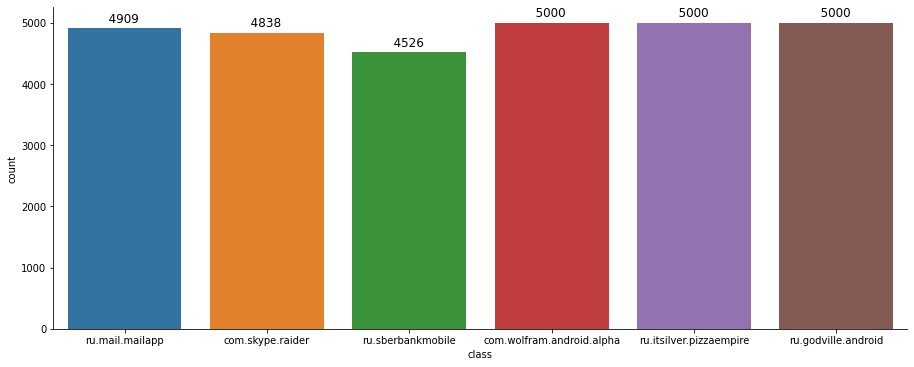

In [155]:
hist = sns.catplot(x='class', data=data, kind="count")
hist.fig.set_size_inches(15,5)
ax = hist.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '           {0:}'.format(p.get_height()),
            color='black', 
            rotation='horizontal', 
            size='large')

Проведём анализ категориальных столбцов.

In [156]:
categorical_col = [col for col in data.columns if data[col].dtypes == 'object' and col != 'class']
data[categorical_col]

,Standard_Deviation_Of_IpDatagram_Size_From_Client,Average_Number_Of_Data_Packets_From_Client,Average_Number_Of_Data_Packets_From_Server,Efficiency_Of_Client,Ratio_Of_Number_Of_Packets,Number_Of_Servings_From_Client
id,,,,,,
1,83.60903,1.48,2.12,0.70405,1,25
3,99.089282,1.666667,1.75,0.731993,1.125,9
4,101.396296,1.555556,1.625,0.744463,1.125,9
5,68.81023,1.357143,1.777778,0.607251,1.037037,28
6,187.188973,1.277778,1.722222,0.823789,1,18
...,...,...,...,...,...,...
29996,184,2,2,138,2,3
29997,184,2,2,138,2,3
29998,204,2,2,191,2,3


Категориальные столбцы имеют неправильный тип данных. 
Изменим тип данных для каждого категориального столбца на реальный и проверим что получилось.

In [157]:
for i in categorical_col:
    data[i] = pd.to_numeric(data[i])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29273 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Network_Layer_Payload_Size_From_Client                     29273 non-null  int64  
 1   Network_Layer_Payload_Size_From_Server                     29273 non-null  int64  
 2   Transport_Layer_Payload_Size_From_Client                   29273 non-null  float64
 3   Transport_Layer_Payload_Size_From_Server                   29273 non-null  float64
 4   Average_Size_On_Transport_Layer_From_Client                29273 non-null  float64
 5   Average_Size_On_Transport_Layer_From_Server                29273 non-null  float64
 6   Average_Size_Data_On_Transport_Layer_From_Client           29273 non-null  float64
 7   Average_Size_Data_On_Transport_Layer_From_Server           29273 non-null  float64
 8   Standa

Также, для того чтобы наша модель могла работать с метками, необходимо перевести их в числовой вид.
Это можно сделать с помощью One-Hot Encoding.

In [158]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_class_cols = pd.DataFrame(OH_encoder.fit_transform(data[['class']].values))
# One-hot encoding переименовывает индкесы, вернём их обратно
OH_class_cols.index = data.index
# One-hot encoding переименовывает столбцы, вернём их обратно
OH_class_cols.columns = OH_encoder.get_feature_names(['class'])
# удалим метки класса из data
OH_data = data.drop('class', axis=1)
# соединим наши данные с изменёнными метками класса
OH_data = pd.concat([OH_data, OH_class_cols], axis=1)

Теперь столбец class разделен на 6 столбцов, в каждом из которых есть значения 0 или 1, обозначающих принадлежность к какому-либо приложению.
Посмотрим как выглядят эти столбцы:

In [159]:
OH_class_cols.head()

,class_com.skype.raider,class_com.wolfram.android.alpha,class_ru.godville.android,class_ru.itsilver.pizzaempire,class_ru.mail.mailapp,class_ru.sberbankmobile
id,,,,,,
1,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0


# 2. Обучение и проверка модели

In [160]:
X = OH_data.drop(OH_class_cols, axis = 1)
y = OH_class_cols
RF_model = RandomForestClassifier(random_state=1)
result = cross_validate(RF_model, X, y, cv=KFold(5, shuffle=True, random_state=0), scoring=['f1_micro', 'roc_auc'], return_estimator =True)

In [161]:
res1_mean_f1 = np.round(result['test_f1_micro'].mean(), 5)
res1_mean_auc = np.round(result['test_roc_auc'].mean(), 5)
print(result['test_f1_micro'], 'mean ->', res1_mean_f1)
print(result['test_roc_auc'], 'mean ->', res1_mean_auc)

[0.994009 0.995721 0.994007 0.99478  0.994778] mean -> 0.99466
[0.999952 0.999968 0.99995  0.999929 0.999932] mean -> 0.99995


Значения близки к сто процентной точности, разберёмся чем это вызвано. Посмотрим на ценность каждого признака.

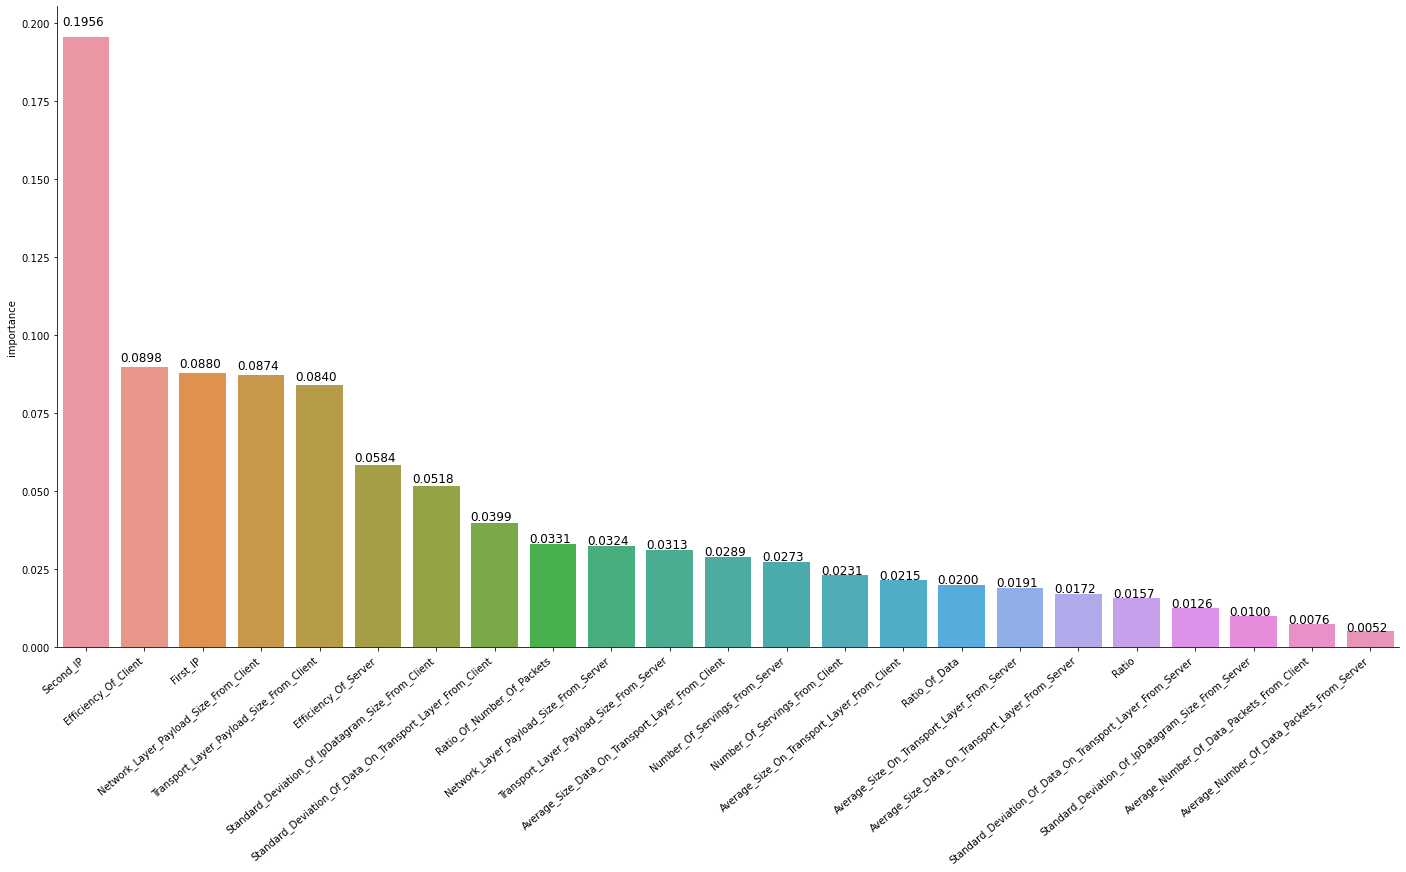

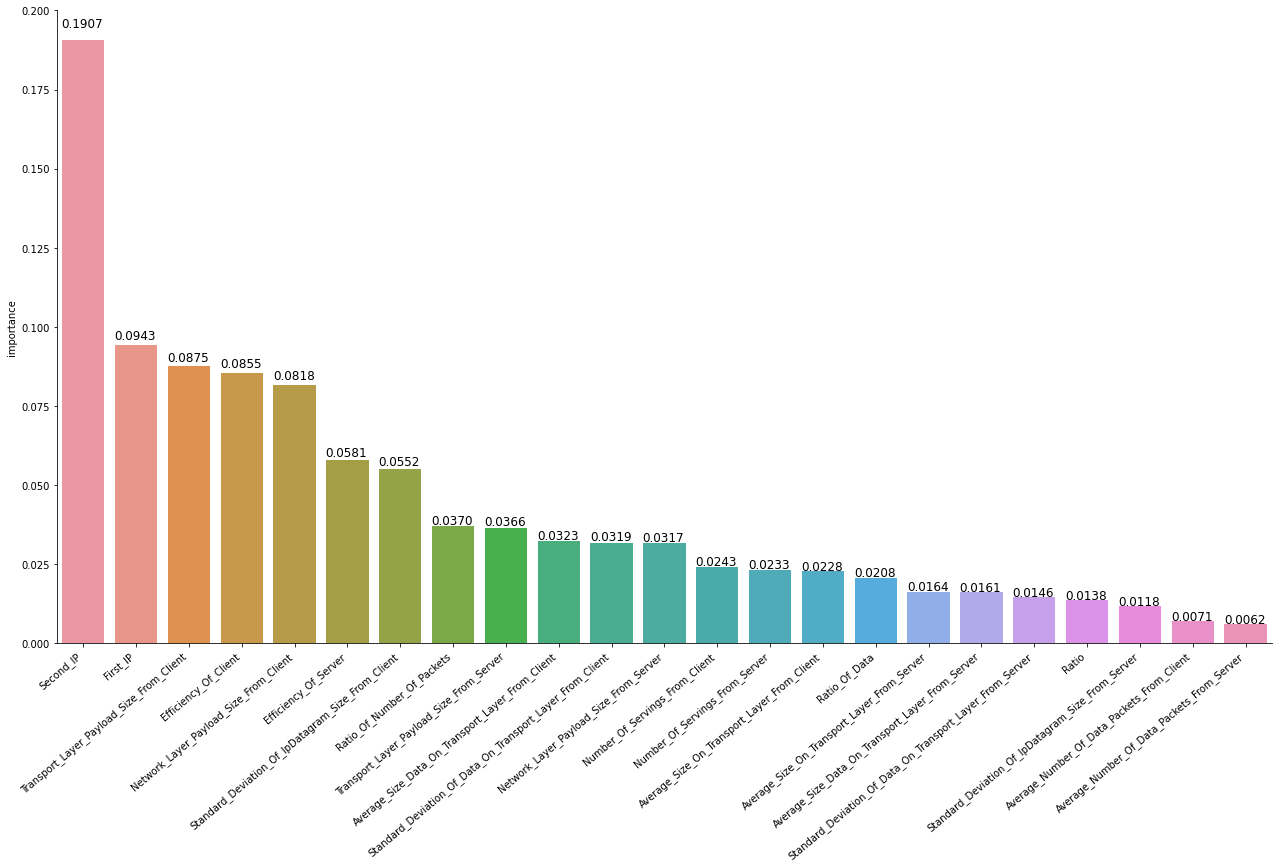

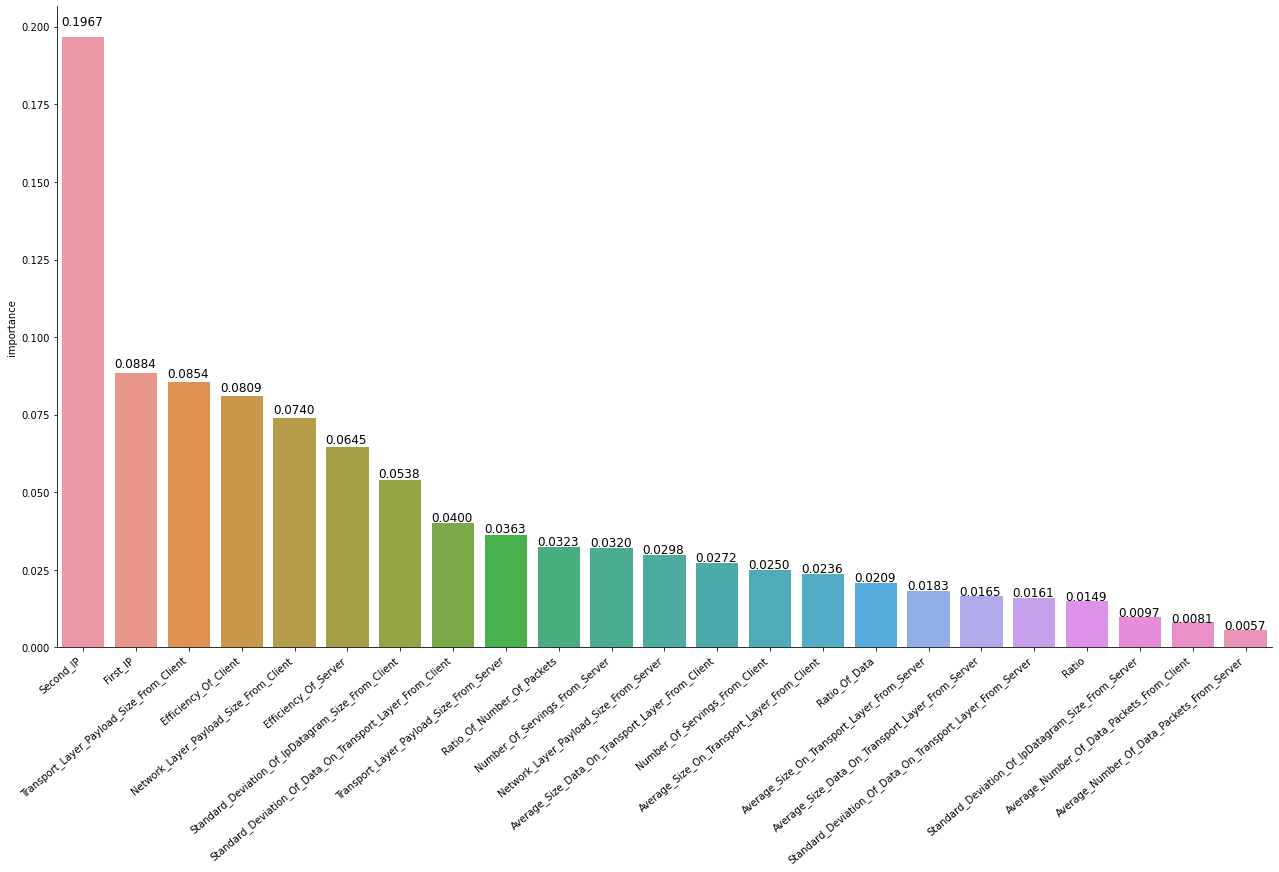

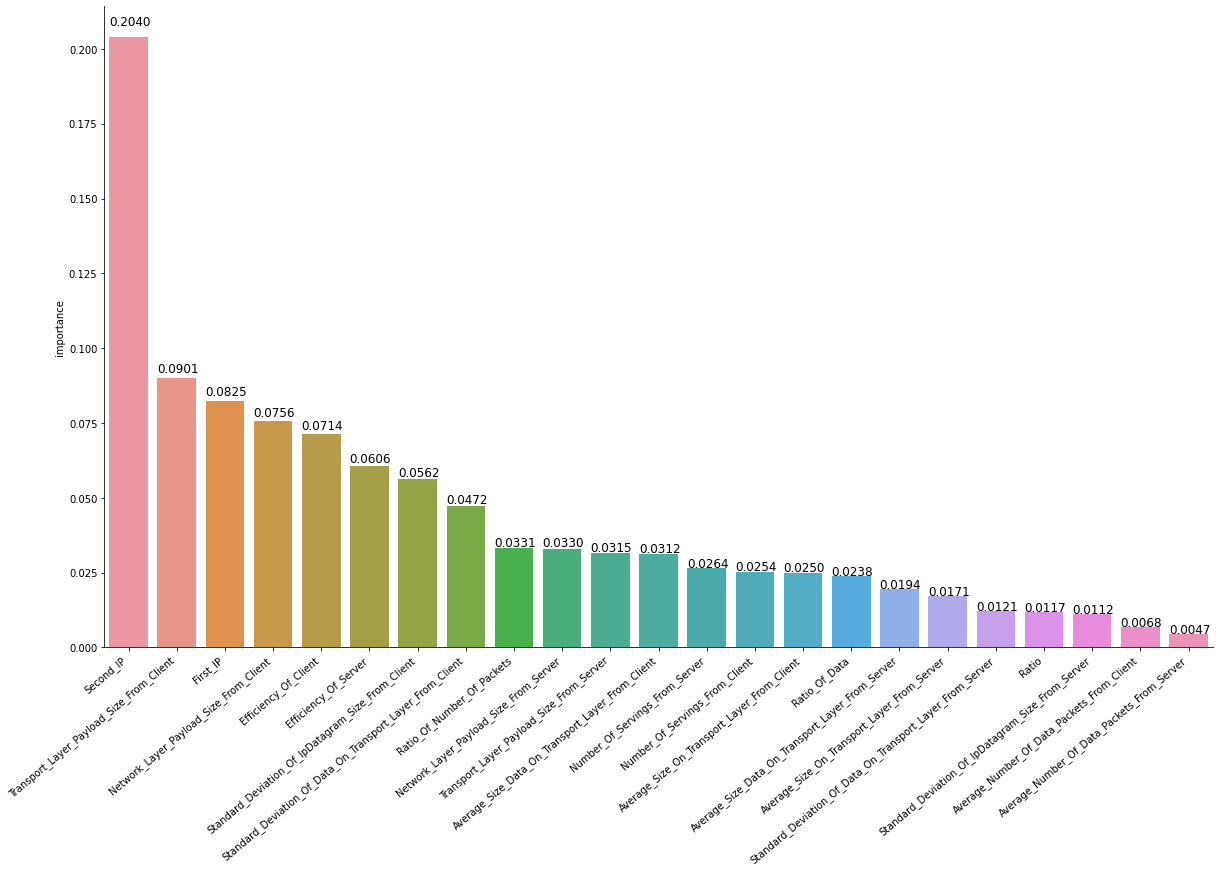

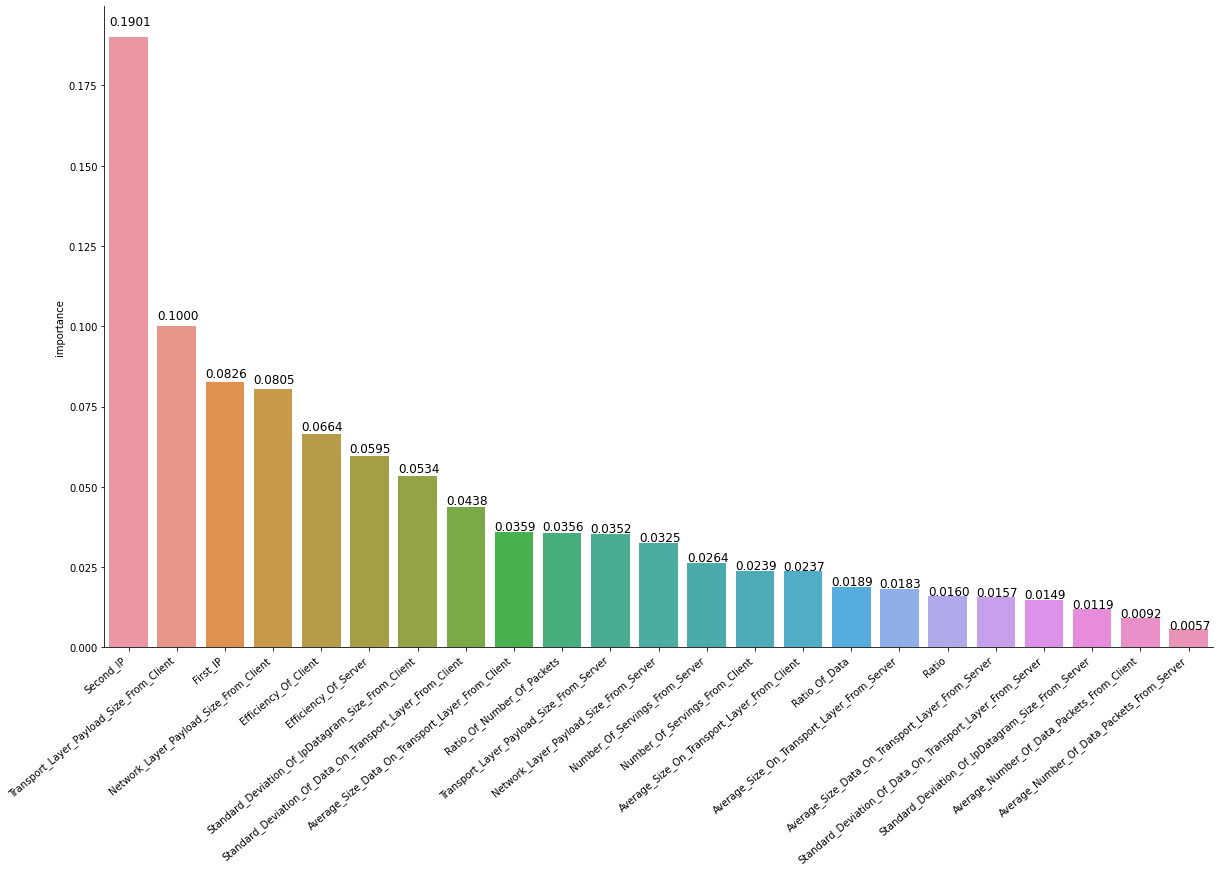

In [162]:
for idx,estimator in enumerate(result['estimator']):
    feature_importances = pd.DataFrame(estimator.feature_importances_, index = X.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    hist = sns.catplot(x=feature_importances.index, y = feature_importances.importance, data=feature_importances, kind="bar")
    hist.fig.set_size_inches(40,10)
    ax = hist.facet_axis(0,0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    for p in ax.patches:
        ax.text(p.get_x() - 0.01, 
                p.get_height() * 1.02, 
               '{0:1.4f}'.format(p.get_height()),
                color='black', 
                rotation='horizontal', 
                size='large')

Как видно из гистограмм ценности признаков, самыми ценными признаками являются - Second_IP(IP-адрес источника), First_IP(IP-адрес назначения), Transport_Layer_Payload_Size_From_Client(Общий объем полезной нагрузки на транспортном уровне от клиента), Efficiency_Of_Client(КПД клиента), Network_Layer_Payload_Size_From_Client(Общий объем полезной нагрузки на транспортном уровне от клиента). Попробуем оставить в наборе только эти пять признаков и посмотрим на результаты.

In [163]:
X_only_5ftrs = X[['Second_IP', 'First_IP', 'Efficiency_Of_Client', 'Transport_Layer_Payload_Size_From_Client', 'Network_Layer_Payload_Size_From_Client']]
result_only_5ftrs = cross_validate(RF_model, X_only_5ftrs, y, cv=KFold(5, shuffle=True, random_state=0), scoring=['f1_micro', 'roc_auc'], return_estimator =True)

In [164]:
res2_mean_f1 = np.round(result_only_5ftrs['test_f1_micro'].mean(), 5)
res2_mean_auc = np.round(result_only_5ftrs['test_roc_auc'].mean(), 5)
print(result_only_5ftrs['test_f1_micro'], 'mean ->', res2_mean_f1)
print(result_only_5ftrs['test_roc_auc'], 'mean ->', res2_mean_auc)

[0.997778 0.997607 0.997522 0.997863 0.998376] mean -> 0.99783
[0.999982 0.999988 0.999882 0.999982 0.999997] mean -> 0.99997


Посмотрим насколько изменились средние значения метрик.

In [165]:
print('All_features     Only_5_features\nF1->  {}    F1->  {}'.format(res1_mean_f1, res2_mean_f1))
print('AUC-> {}    AUC-> {}'.format(res1_mean_auc, res2_mean_auc))
print('\nDifferent  F1 -> {}'.format(np.round(res2_mean_f1 - res1_mean_f1, 5)))
print('Different AUC -> {}'.format(np.round(res2_mean_auc - res1_mean_auc, 5)))

All_features     Only_5_features
F1->  0.99466    F1->  0.99783
AUC-> 0.99995    AUC-> 0.99997

Different  F1 -> 0.00317
Different AUC -> 2e-05


Удаление признаков с малой ценностью улучшило результаты. Значение F-меры увеличилось на 0.00317, а значение под кривой ошибок на 0.00002

# Выводы

С помощью алгоритма Random Forest удалось обучить модель определять приложение по трафику.
Так как IP адрес источника не подвергается шифрованию, то модель определяла приложения в основном по этому признаку, что и обсуловило точность близкую к 100%. Отсюда можно прийти к выводу о том, что разницы в определении приложений с шифрованным и не шифрованным трафиком - нет. Данная точность также обусловленна тем, что в наборе нет трафика неизвестных приложений.